<a href="https://colab.research.google.com/github/shokru/carbon_emissions/blob/main/carbon_portfolios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Firm-specific emissions and portfolio analysis

This notebook presents data on corporate emissions and shows what can happen if they are taken into account in a framework of **modern portfolio theory**.

### Libraries & data

In [2]:
import pandas as pd
import seaborn as sns                    # This is one library for plotting
import matplotlib.pyplot as plt          # Yet another library for visualization
import plotly.express as px
pd.set_option('display.max_rows', 6)     # First 3 and last 3 rows will be shown



We downloaded data for the following firms (except Apple - to be corrected): 

|A - F| G - M |O - Z|
| --- | ----- | --- |
| AAPL (Apple)| GE (General Electric) | ORCL (Oracle)
| BA (Boeing) | HD (Home Depot) | PFE (Pfizer)
| BAC (Bank of America) | IBM | PG (Procter & Gamble)
| C (Citigroup) | INTC (Intel) | T (AT&T)
|CSCO (Cisco) | JNJ (Johnson & Johnson) |  UNH (United Health)
|CVS (CVS Health) | JPM (JP Morgan) | UPS 
|CVX (Chevron) | K (Kellogg) | VZ (Verizon)
|D (Dominion Energy) | MCK (McKesson) | WFC (Wells Fargo)
|DIS (Disney) | MRK (Merck) | WMT (Walmart)
|F (Ford) | MSFT (Microsoft) | XOM (Exxon)

The data is stored in a .xlsx file on **Github**.  
We move toward the coding part & start by loading the libraries/packages/modules.



In [3]:
url = 'https://github.com/shokru/carbon_emissions/blob/main/data_fin.xlsx?raw=true'
data = pd.read_excel(url)
data

,Year,Company,Date,Price,Mkt_cap,Energy_consumption,GHG_scope_3,GHG_total,Return
0,2005,AAPL,2005-12-30,2.2050,60586.5831,NaN,NaN,NaN,1.232609
1,2006,AAPL,2006-12-29,2.6020,72900.7792,NaN,NaN,NaN,0.180136
2,2007,AAPL,2007-12-31,6.0740,173427.0193,265.684,NaN,NaN,1.334748
...,...,...,...,...,...,...,...,...,...
486,2018,XOM,2018-12-31,57.5328,288703.3109,416667.000,NaN,127000.0,-0.151017
487,2019,XOM,2019-12-31,61.6941,295246.5813,416667.000,730000.0,123000.0,0.072517
488,2020,XOM,2020-12-31,39.3540,174287.8102,416667.000,730000.0,123000.0,-0.362131


There are some **missing points**, mostly at the beginning of the sample, because the later missing points have been replaced by the last well-defined value.  
The data is not raw and has been pre-processed.  
**NOTE**: "total" emissions are direct plus indirect emissions (i.e., scope 1&2), while "scope 3" emissions encompass those from the whole value chain. Energy consumption is in thousands of megawatt hours (MWh).     

### Initial plots
We plot some values below.


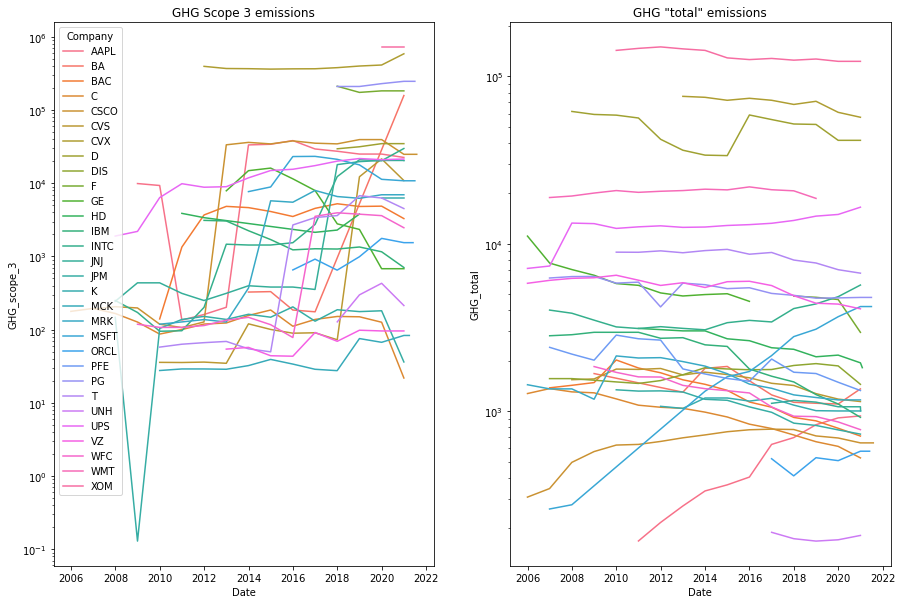

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(15,10))
sns.lineplot(
    ax = ax[0],
    data = data,            # Data source = the filtered data (other method)
    x = "Date",             # x-axis = Date column (of course!)
    y = "GHG_scope_3",      # y-axis = the normalised Close column
    hue = "Company"         # One color for each sector
)
ax[0].set_yscale('log')
ax[0].set_title('GHG Scope 3 emissions')
sns.lineplot(
    ax = ax[1],
    data = data,            # Data source = the filtered data (other method)
    x = "Date",             # x-axis = Date column (of course!)
    y = "GHG_total",        # y-axis = the normalised Close column
    hue = "Company"         # One color for each sector
)
ax[1].set_yscale('log')
ax[1].set_title('GHG "total" emissions')
ax[1].get_legend().remove()

**Comment**: "total" emission curves are smoother.  
Also, disclosure is very firm-specific. Some started early, others later.
Let's sort them into 2 groups: the **green** and the **brown**.   
Green companies have total emissions below the median and it's the opposite for the brown ones.

In [5]:
data['Type'] = data.groupby('Date')['GHG_total'].transform(lambda x: x < x.median()).astype(int)
data['Type'] = data['Type'].replace(0, "Brown")
data['Type'] = data['Type'].replace(1, "Green")
data

,Year,Company,Date,Price,Mkt_cap,Energy_consumption,GHG_scope_3,GHG_total,Return,Type
0,2005,AAPL,2005-12-30,2.2050,60586.5831,NaN,NaN,NaN,1.232609,Brown
1,2006,AAPL,2006-12-29,2.6020,72900.7792,NaN,NaN,NaN,0.180136,Brown
2,2007,AAPL,2007-12-31,6.0740,173427.0193,265.684,NaN,NaN,1.334748,Brown
...,...,...,...,...,...,...,...,...,...,...
486,2018,XOM,2018-12-31,57.5328,288703.3109,416667.000,NaN,127000.0,-0.151017,Brown
487,2019,XOM,2019-12-31,61.6941,295246.5813,416667.000,730000.0,123000.0,0.072517,Brown
488,2020,XOM,2020-12-31,39.3540,174287.8102,416667.000,730000.0,123000.0,-0.362131,Brown


Let's visualize that to check.

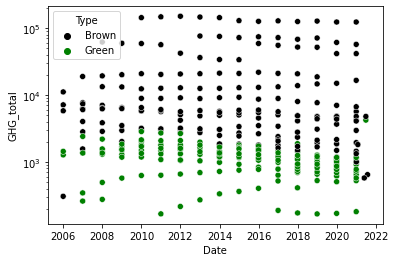

In [8]:
sns.scatterplot(
    data = data,
    x = 'Date',
    y = 'GHG_total',
    hue = 'Type',
    palette = ['black', 'green']
)
plt.yscale('log')

A few errors, but ok overall.

In [16]:
fig = px.scatter(data, 
                 x="Year",
                 y="GHG_total", 
                 color="Type",
                 color_discrete_sequence = ['#666666', '#00CC66'],
                 hover_data=['Company'],
                 log_y = True)
fig.show()

### Profitability & risk

Next, we turn to the financial performance of the stocks.  
We are shifting to the pecuniary part of our analysis.

In [18]:
data.pivot_table(index = 'Company', values = 'Return', aggfunc = 'mean')

,Return
Company,
AAPL,0.467784
BA,0.172010
BAC,0.076952
...,...
WFC,0.047988
WMT,0.109172
XOM,0.035225


Let's plot this...

In [22]:
fig = px.bar(data.pivot_table(index = 'Company', values = 'Return', aggfunc = 'mean').reset_index(), 
             y = 'Return', x = 'Company')
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

Now let's look at correlations.


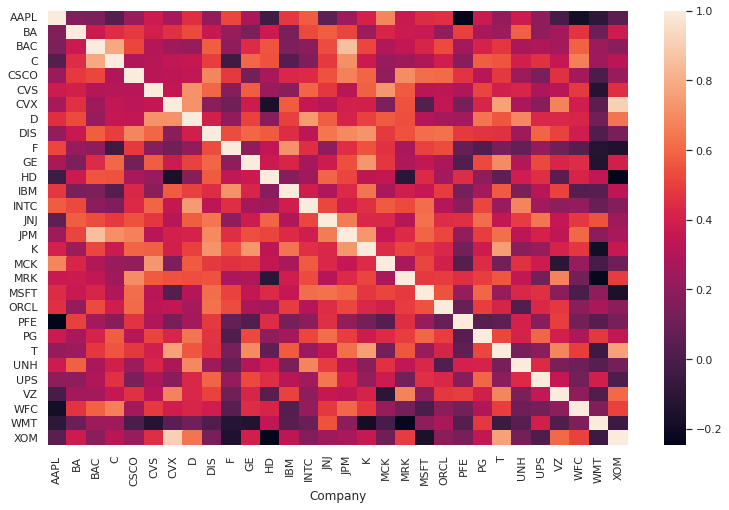

In [58]:
Corr_mat = data.pivot(index = 'Year', columns = 'Company', values = 'Return').fillna(0).corr().reset_index(drop=True)

sns.heatmap(Corr_mat,
            yticklabels = data['Company'].unique())
sns.set(rc={'figure.figsize':(11,7)})